### Bias detection study - L02

Second part of bias detection study will focus on alternative approach to comparing metrics between sets of boards.

Until now this was just the comparison of average values per metric, but the average does not paint the whole picture - it misses the information about the distribution of data. 
Below I will try to implement the statistical methods to compare two distributions to be able to tell if they are different from each other on given confidence level.

For this purpse I will be using "wasserstein_distance" parameter, which measures the effort needed to convert one distribution into another. It can then be used to calculate the  similarity score between 2 distributions - 0 meaning totally different, 1 meaning identical.

In [10]:
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp, wasserstein_distance
import pandas as pd

import bias_metrics


def wasserstein_similarity(x, y, scale=None):
    """
    Similarity = exp(-W / scale).
    If scale is None, use pooled MAD (Median Average Deviation).
    """
    w = wasserstein_distance(x, y)

    if scale is None:
        pooled = np.concatenate([x, y])
        mad = np.median(np.abs(pooled - np.median(pooled)))
        scale = mad if mad > 0 else np.std(pooled)
        if scale == 0:
            scale = 1.0

    return float(np.exp(-w / scale))


First part of the study also contained one mistake regarding the confidence interval determination. The formulas for error margin that I used assumed that the data is normally distributed, which does not have to be the case for many metrics - their distribution shape could be totally irregular, so we must assume it is unknown. 

The only possible way to determine confidence interval for samples taken from unknown distribution is the bootstrap method. Below is the example implementation of bootstrap_ci method which repeatedly samples the given data with replacement, calculates average value from each boot and then draws 2.5th and 97.5th percentile of these averages. This technically gives us 95% confidence that the average lies in the interval defined between these 2 percentiles.

In [11]:
def bootstrap_ci(x, metric_fn=np.mean, n_boot=2000):
    boots = []
    for i in range(n_boot):
        sample = np.random.choice(x, size=len(x), replace=True)
        boots.append(metric_fn(sample))
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    return lower, upper

Later we will also need this helper function to calculate metrics per board in a set of boards:

In [12]:
def get_metrics (boards_list):
    temp_boards_metrics = bias_metrics.make_metrics_dict()
    metrics_per_board = {}

    for board_code in boards_list:
        board_array = np.array([int(x) for x in board_code]).reshape((6,6))
        current_metrics = bias_metrics.calculate_bias_metrics(board_array)

        metrics_per_board[board_code] = current_metrics

    return metrics_per_board

#### Threshold for wasserstein's similarity score

Now, we need to set the threshold for wasserstein's similarity score which will tell us if the examined set of boards is random or biased. 


1. For different sample sizes (n_samples) we will be repeatedly sampling (bootstrap) n boards to the board set A and board set B, all coming from random boards set.

2. For each of these boards in both sets we get their metric values

3. Similarity score is calculated for each metric between the two sets of boards

4. For each sample size we repeat this boot n_shuffles times, recording the similarity scores from each boot

5. This way we simulate that even when sampling from the very same random boards set, we can end up with two subsets that are very dissimilar.

6. Once all shuffles are done, we get the 5th percentile of the similarity score for each metric (pessimistic scenario mentioned above) and set it to be the threshold below which there's only 5% chance that what we see is just bad sampling luck and not a real bias pattern. 

7. This threshold will obviously depend on sample size - the bigger it is, the less impact from the extreme outliers, because the will fall under the 5th percetile. Few samples will only allow to detect very evident bias patterns. With growing number of samples we will be able to detect more and more subtle differences in distribution (higher similarity score threshold).

We start by loading pregenerated random boards list and calculating metrics for them

In [13]:
random_boards_df = pd.read_csv("bias_checks\\random_boards_bruteforce_uniform.csv")
random_boards = random_boards_df['board'].tolist()

metrics_per_board = get_metrics (random_boards)

Let's use 1000 shuffles each time and examine n_boards taken as powers of 2, from 32 to 16384.
I've run this code once and saved the results to csv loadable at the end for visualization.

This code will output a table summarizing the similarity score thresholds that need to be applied for each metric depending on n_samples.

In [14]:
metrics_list = list(bias_metrics.make_metrics_dict().keys())

n_shuffles = 1000

metrics_percentiles_per_n_boards = pd.DataFrame()

if False:
    # n_boards as powers of 2
    for exponent in range (5, 15):
        n_boards = 2 ** exponent

        metric_similarities_all = bias_metrics.make_metrics_dict()
        metric_similarities_all_min ={}
        metric_similarities_all_max ={}
        metric_similarities_all_avg ={}
        metric_similarities_all_perc ={}

        # bootstrap
        for i in range(n_shuffles):

            # progress tracker
            if (i+1) % 100 == 0:
                print(f'Shuffle {i+1} / {int(n_shuffles)}')

            chosen_boards_A = np.random.choice(random_boards, size=n_boards, replace=True).tolist()
            chosen_boards_B = np.random.choice(random_boards, size=n_boards, replace=True).tolist()

            # filter metrics_per_board to only include chosen_boards
            chosen_metrics_A = {board: metrics_per_board[board] for board in chosen_boards_A}
            chosen_metrics_B = {board: metrics_per_board[board] for board in chosen_boards_B}


            for metric in metrics_list:
                metric_values_A = [chosen_metrics_A[board][metric] for board in chosen_boards_A]
                metric_values_B = [chosen_metrics_B[board][metric] for board in chosen_boards_B]

                sim = wasserstein_similarity(metric_values_A, metric_values_B)
                metric_similarities_all[metric].append(sim)

        for metric in metrics_list:
            metric_similarities_all_min[metric] = np.round(np.min(metric_similarities_all[metric]), 3)
            metric_similarities_all_max[metric] = np.round(np.max(metric_similarities_all[metric]), 3)
            metric_similarities_all_avg[metric] = np.round(np.mean(metric_similarities_all[metric]), 3)

            metric_similarities_all_perc[metric] = np.round(np.percentile(metric_similarities_all[metric], 5), 3)


        metrics_sim_all = pd.DataFrame.from_dict(metric_similarities_all_avg, orient='index', columns=['similarity'])
        metrics_sim_all['min'] = pd.Series(metric_similarities_all_min)
        metrics_sim_all['max'] = pd.Series(metric_similarities_all_max)
        metrics_sim_all[f'n{n_boards}'] = pd.Series(metric_similarities_all_perc)

        print("\nMetrics similarities for n_boards =", n_boards)
        print(metrics_sim_all)

        metrics_percentiles_per_n_boards = pd.concat([metrics_percentiles_per_n_boards, metrics_sim_all[f'n{n_boards}']], axis=1)

    metrics_percentiles_per_n_boards.to_csv("bias_checks\\metrics_percentiles_per_n_boards.csv")

metrics_percentiles_per_n_boards = pd.read_csv("bias_checks\\metrics_percentiles_per_n_boards.csv", index_col=0)
print(f"\nFINAL SUMMARY:\n5th percentile of metrics similarity score per n_boards:")
print(metrics_percentiles_per_n_boards)


FINAL SUMMARY:
5th percentile of metrics similarity score per n_boards:
                             n32    n64   n128   n256   n512  n1024  n2048  n4096  n8192  n16384
avg_2seg_orient            0.608  0.730  0.804  0.859  0.900  0.930  0.953  0.968  0.978   0.985
avg_3seg_orient            0.606  0.709  0.791  0.836  0.886  0.921  0.938  0.960  0.969   0.979
seg2_same_orient           0.606  0.708  0.779  0.836  0.889  0.919  0.939  0.960  0.970   0.978
seg2_3_same_orient         0.620  0.702  0.771  0.845  0.882  0.913  0.939  0.957  0.970   0.979
seg2_dist_to_left          0.404  0.527  0.636  0.729  0.802  0.863  0.905  0.942  0.965   0.975
seg2_dist_to_right         0.380  0.519  0.626  0.729  0.797  0.855  0.905  0.937  0.958   0.973
seg2_dist_to_upper         0.404  0.519  0.656  0.734  0.800  0.874  0.911  0.941  0.963   0.975
seg2_dist_to_bottom        0.404  0.524  0.645  0.731  0.805  0.871  0.909  0.940  0.962   0.975
seg3_dist_to_left          0.458  0.570  0.682  0.752 

Of course it is not viable to calculate the threshold values for each number of samples, so if we have something inbetween the powers of 2, we can either interpolate or safely assume the lower threshold value of the bound.

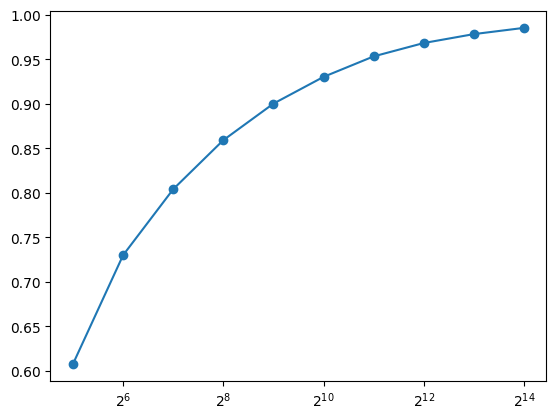

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure()
x = [2**i for i in range(5, 15)]

plt.plot(x, metrics_percentiles_per_n_boards.loc['avg_2seg_orient'], marker='o')
plt.xscale('log', base=2)

#### Test on previous biased examples

Now that we established a new, more sophisticated method of bias distinction, we will revisit example biased boards presented in first part of the study and see if we are able to detect bias in the same metrics (or even more?) as last time, when we were just comparing the mean values.

We have 10k biased board samples, so we will use similarity threshold values as per 8192 samples (should be fairly close)

In [16]:
biased_boards_df = pd.read_csv("bias_checks\\biased_2seg_close_10000.csv")
biased_boards = biased_boards_df['board'].tolist()

metrics_per_board_biased = get_metrics (biased_boards)

metrics_per_board_random = metrics_per_board #already calculated before

metric_similarities = {}
metric_averages_A = {}
metric_averages_B = {}

for metric in metrics_list:
    metric_values_A = [metrics_per_board_random[board][metric] for board in random_boards]
    metric_values_B = [metrics_per_board_biased[board][metric] for board in biased_boards]

    sim = wasserstein_similarity(metric_values_A, metric_values_B)
    metric_similarities[metric] = round(sim, 3)

    metric_averages_A[metric] = np.round(np.mean(metric_values_A), 4)
    metric_averages_B[metric] = np.round(np.mean(metric_values_B), 4)


metrics_sim = pd.DataFrame.from_dict(metric_similarities, orient='index', columns=['distribution similarity'])
metrics_sim ['threshold'] = metrics_percentiles_per_n_boards['n8192']
metrics_sim ['bias confirmed'] = metrics_sim['distribution similarity'] < metrics_sim['threshold']
metrics_sim ['avg_random'] = pd.Series(metric_averages_A)
metrics_sim ['avg_biased'] = pd.Series(metric_averages_B)

print("\nMetrics similarities between random boards and biased relational boards:")
print(metrics_sim)


Metrics similarities between random boards and biased relational boards:
                           distribution similarity  threshold  bias confirmed  avg_random  avg_biased
avg_2seg_orient                              0.996      0.978           False     -0.0032      0.0044
avg_3seg_orient                              0.990      0.969           False     -0.0066      0.0038
seg2_same_orient                             0.993      0.970           False      0.5082      0.5046
seg2_3_same_orient                           0.994      0.970           False      0.2605      0.2632
seg2_dist_to_left                            0.889      0.965            True      2.2628      2.2612
seg2_dist_to_right                           0.887      0.958            True      2.2380      2.2377
seg2_dist_to_upper                           0.896      0.963            True      2.2400      2.2578
seg2_dist_to_bottom                          0.895      0.962            True      2.2592      2.2433
seg3_dis

For reference, this is what we were able to detect by just comparing the mean values in previous study:

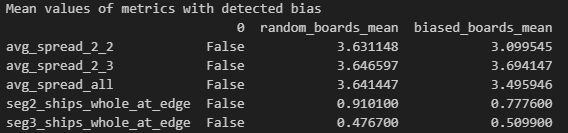

Metrics in which we detected bias in mean value variation are correct to appear in similarity score approach - different mean value enforces different data distrubution. Interestingly, similarity score approach was able to detect bias in metrics with very tiny mean variation.

Let's visually examine the random and biased distributions.

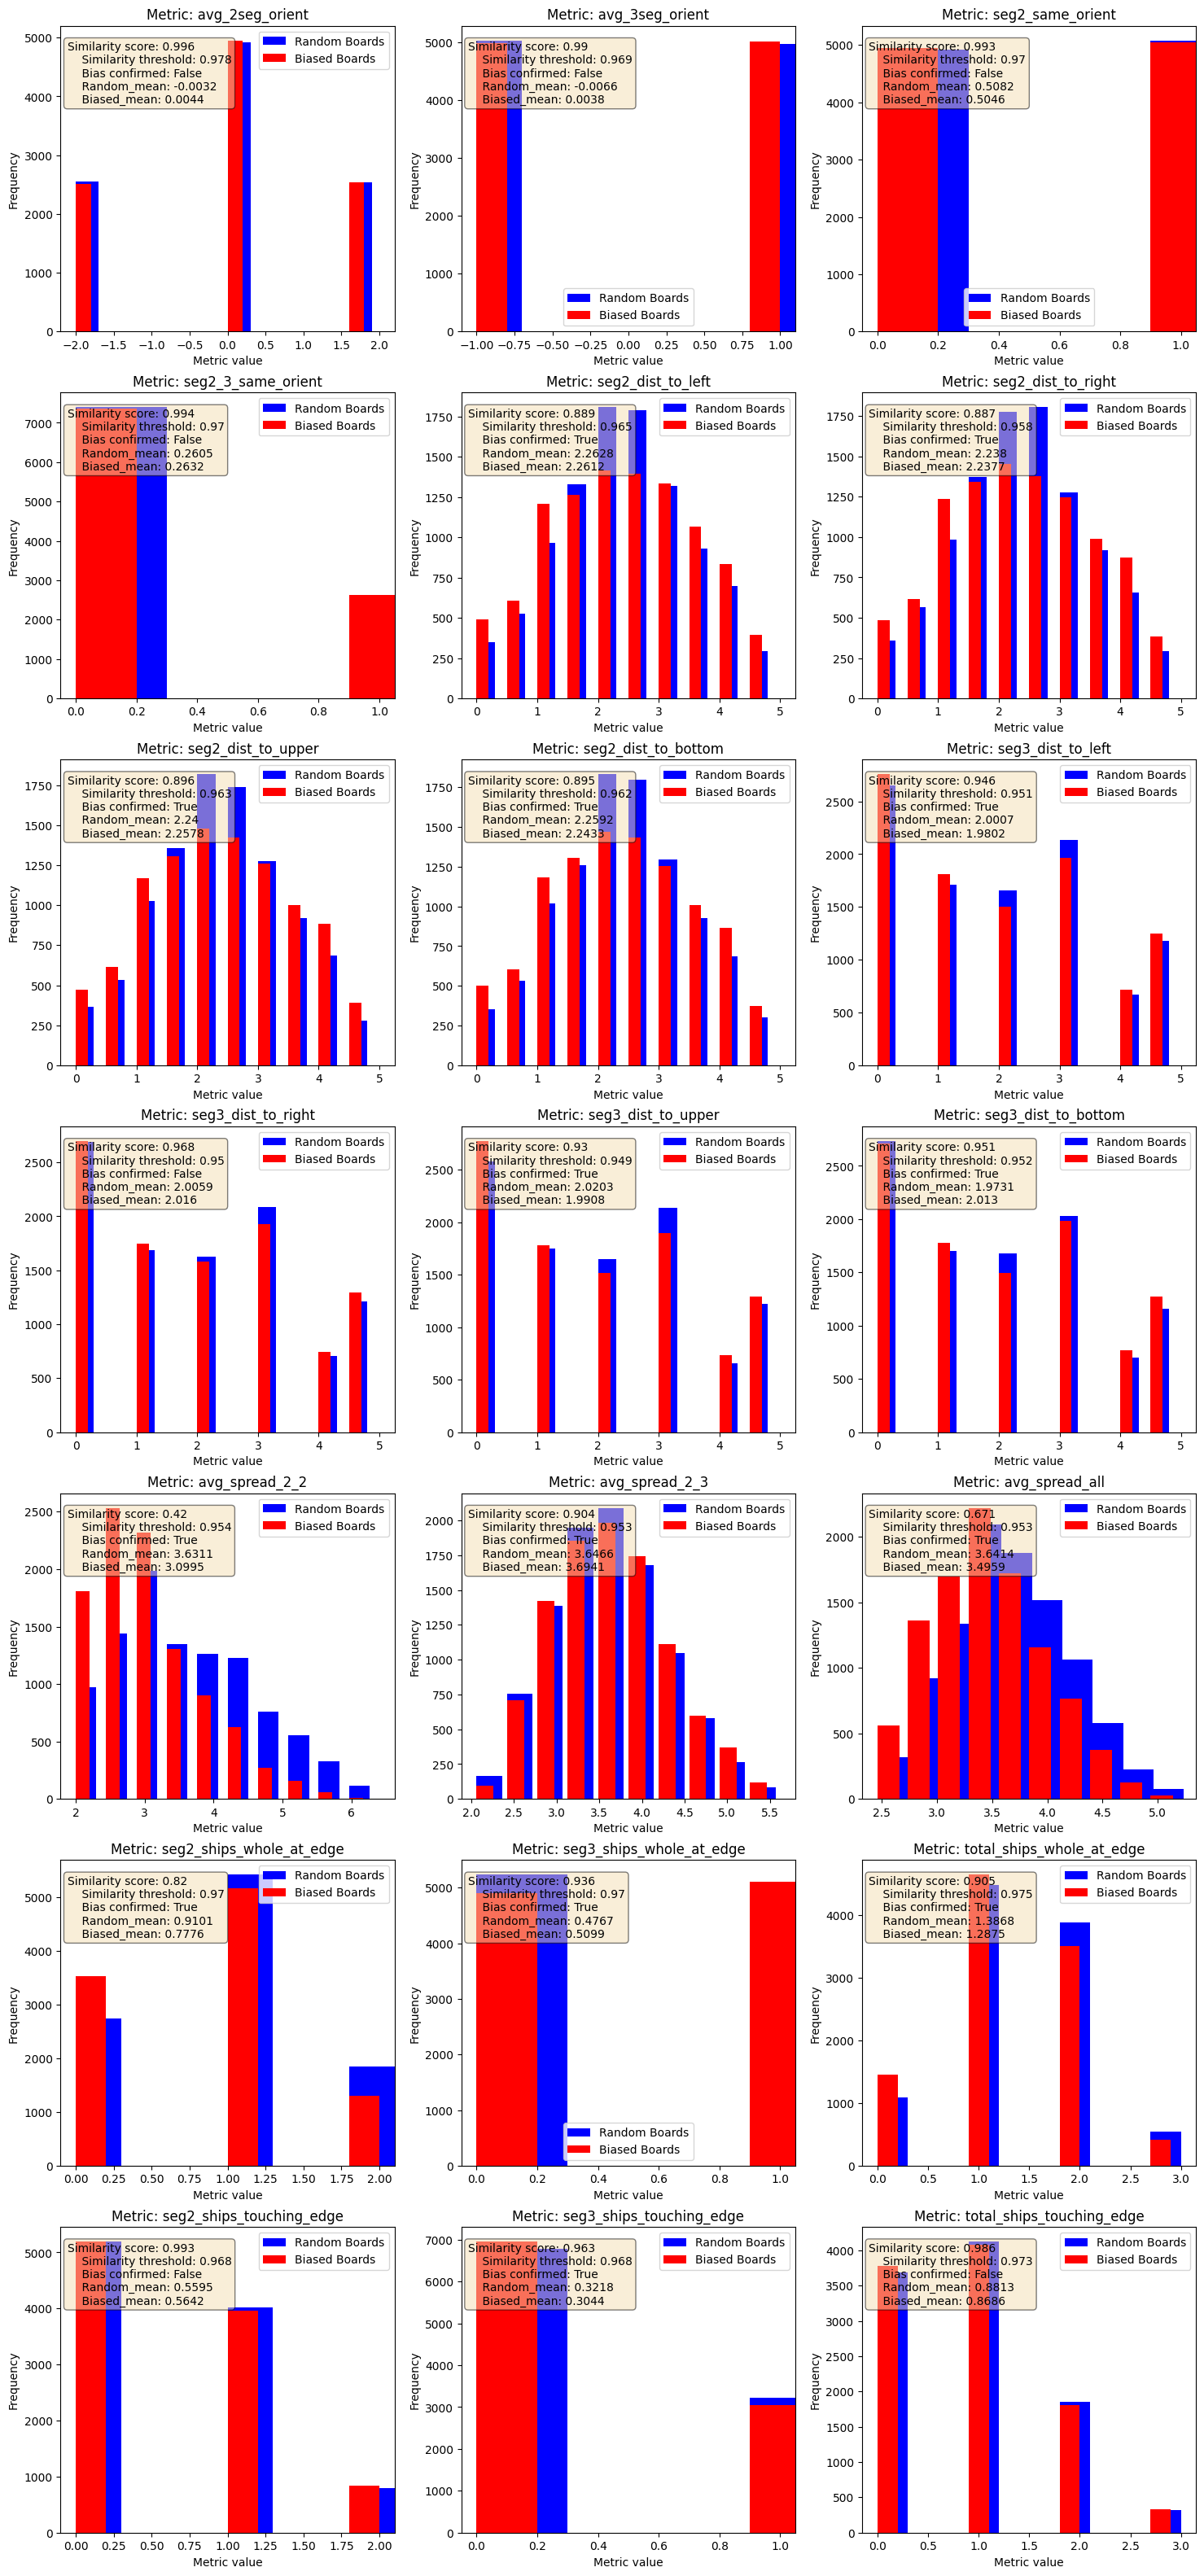

In [17]:
fig, axs = plt.subplots(7, 3, figsize=(18, 40))

for id, metric in enumerate(metrics_list):

    if metric == "seg2_3_same_orient" or metric == "seg2_same_orient": # histogram won't accept boolean values
        random_data_for_histogram = [float(metrics_per_board_random[board][metric]) for board in  random_boards]
        biased_data_for_histogram = [float(metrics_per_board_biased[board][metric]) for board in  biased_boards]
    else:
        random_data_for_histogram = [metrics_per_board_random[board][metric] for board in  random_boards]
        biased_data_for_histogram = [metrics_per_board_biased[board][metric] for board in  biased_boards]
    
    axes = axs.flatten()
    ax = axes[id]

    ax.hist(random_data_for_histogram, bins=10, alpha=1.0, label='Random Boards', color='blue', width=0.3)
    ax.hist(biased_data_for_histogram, bins=10, alpha=1.0, label='Biased Boards', color='red', width=0.2)
    ax.text(0.02, 0.95,\
    f'Similarity score: {metrics_sim.loc[metric, "distribution similarity"]}\n\
    Similarity threshold: {metrics_sim.loc[metric, "threshold"]}\n\
    Bias confirmed: {metrics_sim.loc[metric, "bias confirmed"]}\n\
    Random_mean: {metrics_sim.loc[metric, "avg_random"]}\n\
    Biased_mean: {metrics_sim.loc[metric, "avg_biased"]}',\
    transform=ax.transAxes, verticalalignment='top', ha="left", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    ax.legend()
    
    ax.set_xlabel('Metric value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Metric: {metric}')

That conclues second part of bias detection study. Distribution similarity score is definitely a better approach then mean values comparison.